# Understanding the Delay Filter

This notebook explains and demonstrates the concept of delay filtering for foreground removal. We will focus on two key things:

1.  **Explaining the `simple_delay_filter`:** How does it work and what does its `delay_notch_width` parameter mean?
2.  **Comparing to a Physical Cut:** How does this simple filter compare to a filter where we specify the delay cut directly in nanoseconds (ns)?

The overall goal is to remove a bright, spectrally smooth foreground to reveal a fainter, more complex astrophysical signal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib and plotting style setup
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 7)})

## 1. Creating a Test Signal

First, let's create a realistic test spectrum. We'll simulate a dataset with 1024 frequency channels spanning a 400 MHz bandwidth (from 400 to 800 MHz), similar to our main simulation.

The spectrum will have two components:
- **A bright, smooth foreground:** We'll model this with a simple power law.
- **A faint "signal of interest":** We'll model this as a wide Gaussian profile. This represents the kind of signal we want to recover.

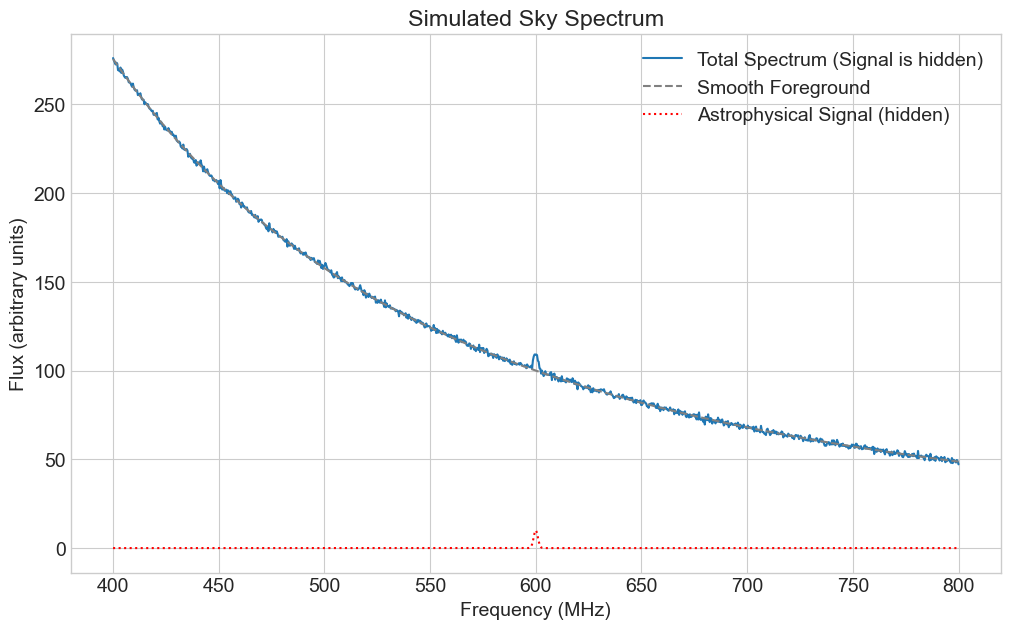

In [11]:
# Define our frequency axis
N_CHANNELS = 1024
FREQ_MIN_MHZ = 400.0
FREQ_MAX_MHZ = 800.0
freqs_mhz = np.linspace(FREQ_MIN_MHZ, FREQ_MAX_MHZ, N_CHANNELS)

# 1. Create the smooth foreground component
nu_ref = np.mean(freqs_mhz)
foreground = 100 * (freqs_mhz / nu_ref)**-2.5

# 2. Create the fainter, broad "astrophysical" signal
signal_center = 600 # MHz
signal_width = 1   # MHz
signal_amp = 10
astrophysical_signal = signal_amp * np.exp(-0.5 * ((freqs_mhz - signal_center) / signal_width)**2)

# 3. Add them together with some noise
noise = np.random.normal(0, 1.0, N_CHANNELS)
total_spectrum = foreground + astrophysical_signal + noise

# Plot the components
plt.plot(freqs_mhz, total_spectrum, label='Total Spectrum (Signal is hidden)')
plt.plot(freqs_mhz, foreground, label='Smooth Foreground', ls='--', color='gray')
plt.plot(freqs_mhz, astrophysical_signal, label='Astrophysical Signal (hidden)', ls=':', color='red')
plt.title("Simulated Sky Spectrum")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Flux (arbitrary units)")
plt.legend()
plt.show()

## 2. The `simple_delay_filter`

This filter works by transforming the spectrum into its Fourier conjugate domain, which is called **delay space**. Spectrally smooth components like our foreground have all their power at low delay values (close to $\tau=0$). By "notching out" or zeroing these low-delay modes and then inverse-transforming back to the frequency domain, we can remove the foreground.

### Understanding the `delay_notch_width` Parameter

The user is accustomed to delay cuts in nanoseconds (ns), but this filter's `delay_notch_width` is an integer representing a number of channels in the Fourier-transformed array. How do they relate?

The relationship depends on the **total bandwidth** of your spectrum.

1.  The resolution in delay space is given by $d\tau = 1 / B$, where $B$ is the total bandwidth in Hz.
2.  The $k^{th}$ channel in the Fourier array corresponds to a delay of $\tau_k = k \times d\tau = k / B$.
3.  The `delay_notch_width` is the number of channels ($k$) we are zeroing out.

Therefore, the maximum delay being filtered (the "delay cut") is:

$$ \tau_{cut} (s) = \frac{\text{delay notch width}}{\text{Bandwidth (Hz)}} $$

Let's calculate it for our simulation:
- **Bandwidth:** 800 MHz - 400 MHz = 400 MHz = $400 \times 10^6$ Hz.
- **If we choose `delay_notch_width = 40`:**
  $$ \tau_{cut} (s) = \frac{40}{400 \times 10^6 \text{ Hz}} = 100 \times 10^{-9} \text{ s} = 100 \text{ ns} $$

So, for our specific frequency setup, a `delay_notch_width` of **40** corresponds to a physical delay cut of **100 ns**.

In [12]:
def apply_simple_delay_filter(spectrum, delay_notch_width: int = 15):
    """Simulates a basic delay filter by notching out Fourier modes."""
    # A weights array is not strictly needed for this demonstration
    weights = np.ones_like(spectrum)
    
    # Go to delay space (Fourier space)
    delay_spectrum = np.fft.fft(spectrum * weights)
    
    # Notch out the low-delay (spectrally smooth) modes
    delay_spectrum[:delay_notch_width] = 0
    delay_spectrum[-delay_notch_width:] = 0
    
    # Return to frequency space
    filtered_spectrum = np.fft.ifft(delay_spectrum)
    
    return filtered_spectrum.real

# Apply the filter with a notch width of 40 (which we calculated is ~100 ns)
filtered_simple = apply_simple_delay_filter(total_spectrum, delay_notch_width=40)

## 3. A More Physical Delay Filter

To make the comparison clearer, let's create a second filter that works directly with a `delay_cut_ns` argument. This function will perform the calculation from Section 2 internally to figure out how many Fourier channels it needs to cut.

In [13]:
def apply_physical_delay_filter(spectrum, freqs_mhz, delay_cut_ns: float):
    """Applies a delay filter using a physical cut in nanoseconds."""
    # 1. Calculate the total bandwidth in Hz
    bandwidth_hz = (np.max(freqs_mhz) - np.min(freqs_mhz)) * 1e6
    if bandwidth_hz == 0:
        return spectrum
        
    # 2. Convert the desired delay cut into an integer number of channels
    delay_cut_s = delay_cut_ns * 1e-9
    notch_width = int(np.round(delay_cut_s * bandwidth_hz))
    print(f"A delay cut of {delay_cut_ns} ns corresponds to a notch_width of {notch_width} channels.")
    
    # 3. Apply the simple filter with the calculated notch width
    return apply_simple_delay_filter(spectrum, delay_notch_width=notch_width)

# Apply this filter with a 100 ns cut
filtered_physical = apply_physical_delay_filter(total_spectrum, freqs_mhz, delay_cut_ns=100)

A delay cut of 100 ns corresponds to a notch_width of 40 channels.


In [16]:
# In ohm_search_simulator.py, replace your old filter functions with this one

from scipy.signal.windows import tukey

def apply_windowed_delay_filter(
    spectrum: np.ndarray,
    weights: np.ndarray,
    freqs_mhz: np.ndarray,
    delay_cut_ns: float
) -> np.ndarray:
    """
    Applies a more realistic delay filter by using a smooth window function
    to suppress foreground-dominated modes in the delay domain.

    This method is more faithful to a real pipeline filter as it is less
    prone to ringing artifacts than a "brick-wall" cut.

    Args:
        spectrum: The 1D input data slice.
        weights: The weights array (0 for flagged channels).
        freqs_mhz: The frequency axis in MHz, used to calculate the cut.
        delay_cut_ns: The delay at which the filter's suppression begins, in ns.

    Returns:
        The real part of the filtered spectrum.
    """
    # 1. Calculate the total bandwidth in Hz
    bandwidth_hz = (np.max(freqs_mhz) - np.min(freqs_mhz)) * 1e6
    if bandwidth_hz == 0:
        return spectrum
        
    # 2. Convert the desired delay cut into an integer number of channels
    delay_cut_s = delay_cut_ns * 1e-9
    notch_width = int(np.round(delay_cut_s * bandwidth_hz))
    
    # 3. Create a smooth windowing function
    # A Tukey window is flat in the middle with tapered cosine edges.
    # We create a window that is the size of the notch on each side.
    num_modes_to_window = notch_width * 2
    if num_modes_to_window <= 0 or num_modes_to_window >= len(spectrum):
        return np.zeros_like(spectrum) # Return zero if the filter is too wide
        
    window = tukey(num_modes_to_window, alpha=1.0) # alpha=1.0 is a full cosine taper
    
    # The filter is a multiplication in the Fourier domain. 1 passes, 0 blocks.
    fft_filter = np.ones_like(spectrum, dtype=float)
    fft_filter[:notch_width] = window[:notch_width]
    fft_filter[-notch_width:] = window[notch_width:]
    
    # 4. Apply the filter
    delay_spectrum = np.fft.fft(spectrum * weights)
    filtered_delay_spectrum = delay_spectrum * fft_filter
    filtered_spectrum = np.fft.ifft(filtered_delay_spectrum)
    
    return filtered_spectrum.real

## 4. Comparison of Results

Now let's plot the results. We want to see if both filters successfully removed the bright, smooth foreground, revealing the underlying astrophysical signal.

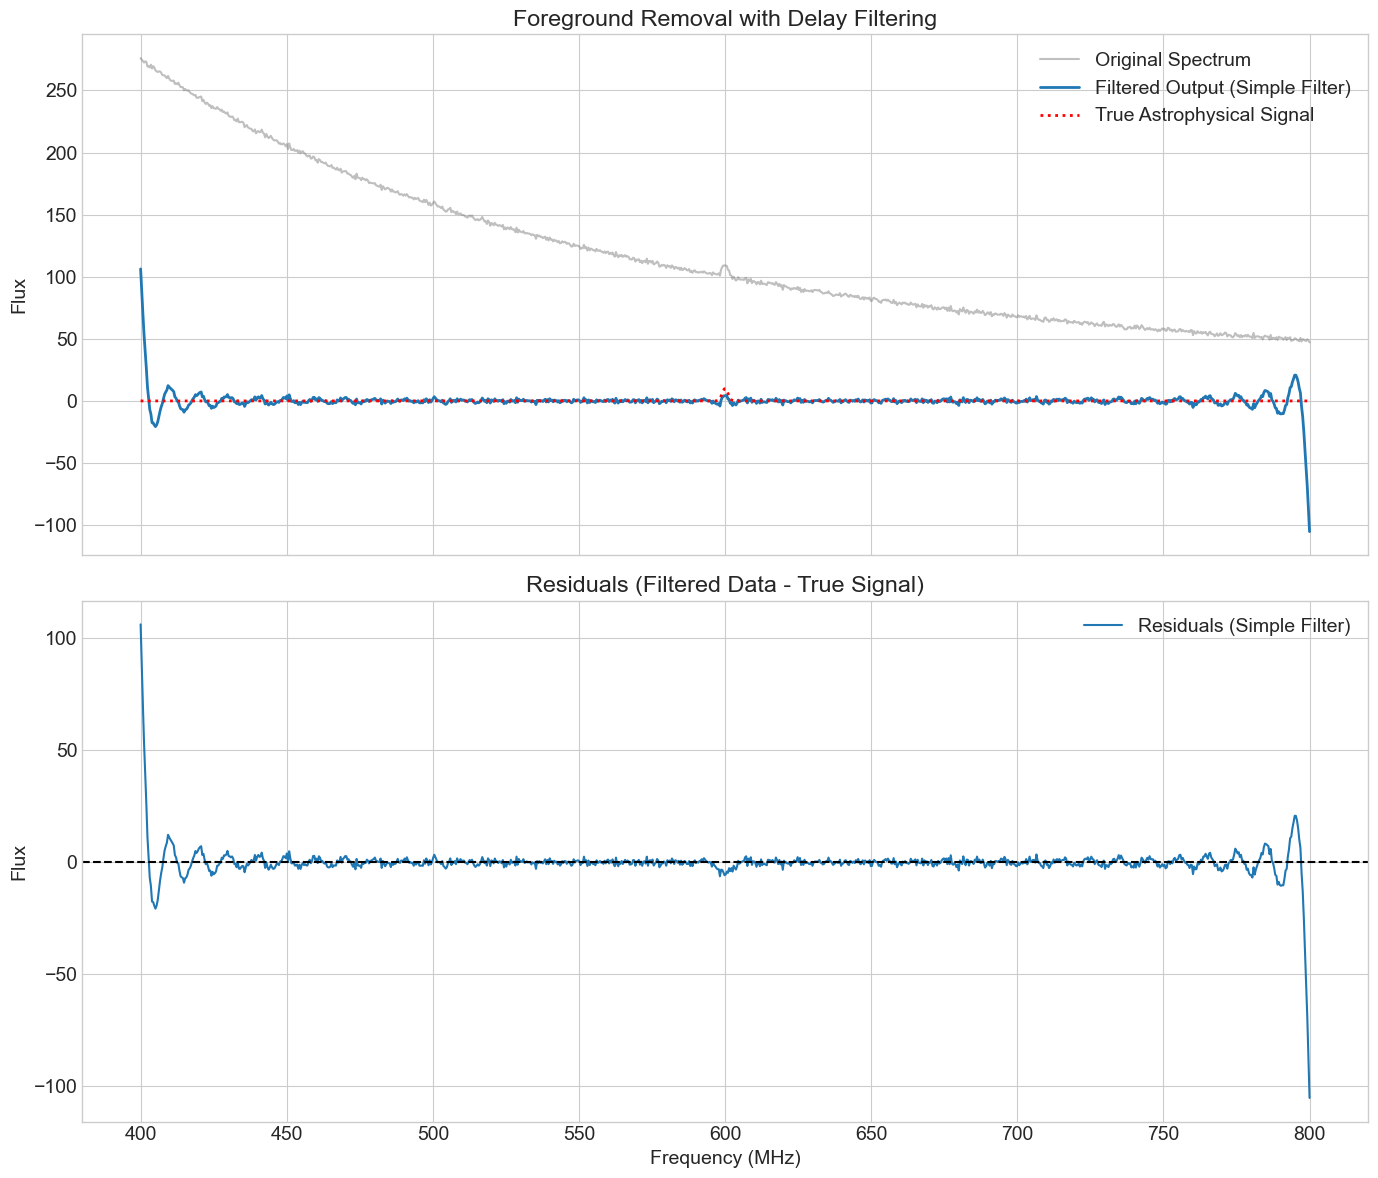

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# --- Top Panel: Original vs. Filtered Spectra ---
axs[0].plot(freqs_mhz, total_spectrum, color='gray', alpha=0.5, label='Original Spectrum')
axs[0].plot(freqs_mhz, filtered_simple, lw=2, label='Filtered Output (Simple Filter)')
axs[0].plot(freqs_mhz, astrophysical_signal, color='red', ls=':', lw=2, label='True Astrophysical Signal')
axs[0].set_title("Foreground Removal with Delay Filtering")
axs[0].set_ylabel("Flux")
axs[0].legend()
axs[0].grid(True)

# --- Bottom Panel: Residuals ---
# The residual is the difference between the filtered output and the true signal
residual_simple = filtered_simple - astrophysical_signal
residual_physical = filtered_physical - astrophysical_signal

axs[1].plot(freqs_mhz, residual_simple, label='Residuals (Simple Filter)')
axs[1].axhline(0, ls='--', color='k')
axs[1].set_title("Residuals (Filtered Data - True Signal)")
axs[1].set_xlabel("Frequency (MHz)")
axs[1].set_ylabel("Flux")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Conclusion

As the plots show, both methods do an excellent job of removing the smooth foreground component. The top plot shows that the filtered output (blue line) no longer has the steep power-law slope and instead sits near zero, revealing the Gaussian "signal of interest" (red dotted line) that was previously hidden.

The bottom plot shows the residuals after subtracting the true signal from our filtered data. The residuals are close to zero, indicating the filter removed the foreground without significantly distorting the underlying signal we care about.

This notebook confirms that the `simple_delay_filter` is working as intended and clarifies that its `delay_notch_width` parameter is directly proportional to a physical delay cut in nanoseconds, with the conversion factor being the total bandwidth of the observation.